# Adaptive RAG agent with LangGraph & Claude3

We'll combine ideas from paper RAG papers into a RAG agent:

- **Routing:**  Adaptive RAG ([paper](https://arxiv.org/abs/2403.14403)). Route questions to different retrieval approaches
- **Fallback:** Corrective RAG ([paper](https://arxiv.org/pdf/2401.15884.pdf)). Fallback to web search if docs are not relevant to query
- **Self-correction:** Self-RAG ([paper](https://arxiv.org/abs/2310.11511)). Fix answers w/ hallucinations or don’t address question

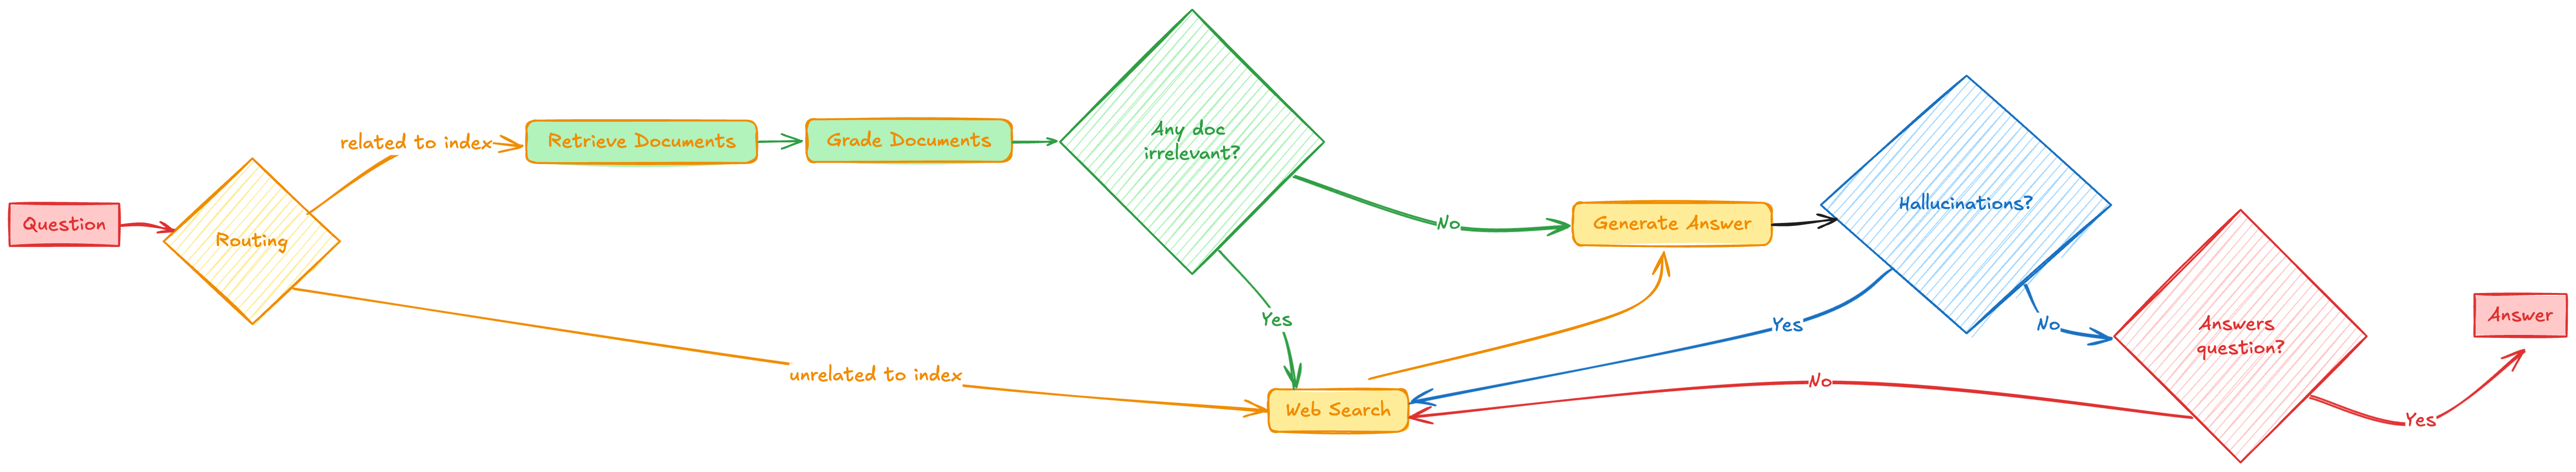
## Models

#### Embedding
 
Sign up for [Voyage](https://dash.voyageai.com/?ref=anthropic):

```
export VOYAGE_API_KEY="<your secret key>"
pip install -U voyageai
```

### LLM

Sign up for [Anthropic Claude](https://docs.anthropic.com/en/api/getting-started)
```
curl ht```tps://api.anthropic.com/v1/messages \
     --header "x-api-key: $ANTHROPIC_API_KEY" \
     --header "anthropic-version: 2023-06-01" \
     --header "content-type: application/json" \
     --data \
'{
    "model": "claude-3-5-sonnet-20241022",
    "max_tokens": 1024,
    "messages": [
        {"role": "user", "content": "Hello, world"}
    ]
}'
```

Sign up for [Google Custom Serch API](https://developers.google.com/custom-search/v1/overview). You will need the following:
1. API Key
2. Programmable Custom Search Engine ID

In [7]:
%%capture --no-stderr
%pip install -U voyageai langchain-voyageai langchain_community tiktoken langchainhub langchain langgraph chromadb gpt4all langchain-text-splitters google-api-python-client html2text transformers bs4 sentence_transformers langchain-anthropic langchain_community

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


### Tracing (optional)

In [1]:
# Load API key from secrets.json

import os
import json

os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"

def get_secrets():
    with open('secrets.json') as secrets_file:
        secrets = json.load(secrets_file)

    return secrets


if __name__ == "__main__":
    secrets = get_secrets()
    os.environ["ANTHROPIC_API_KEY"]  = secrets.get("ANTHROPIC_API_KEY")
    os.environ["LANGCHAIN_API_KEY"]  = secrets.get("LANGCHAIN_API_KEY")
    os.environ["GOOGLE_API_KEY"] = secrets.get("GOOGLE_API_KEY")
    os.environ["GOOGLE_CSE_ID"] = secrets.get("GOOGLE_CSE_ID")
    os.environ["HF_TOKEN"] = secrets.get("HF_TOKEN")


In [2]:
### Index

from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain.embeddings import SentenceTransformerEmbeddings



urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
    "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/",
]

docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]

text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=250, chunk_overlap=0
)
doc_splits = text_splitter.split_documents(docs_list)
# Embedding Model
embeddings = SentenceTransformerEmbeddings(model_name="all-MiniLM-L6-v2")

# Add to vectorDB
vectorstore = Chroma.from_documents(
    documents=doc_splits,
    collection_name="rag-chroma",
    embedding=embeddings,
)
retriever = vectorstore.as_retriever()

USER_AGENT environment variable not set, consider setting it to identify your requests.
/var/folders/hc/6q3d24jj6nzcjnd5yn8snvy80000gn/T/ipykernel_69411/2916182410.py:24: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embeddings = SentenceTransformerEmbeddings(model_name="all-MiniLM-L6-v2")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
### Retrieval Grader

from langchain_anthropic import ChatAnthropic
from langchain_core.output_parsers import JsonOutputParser
from langchain_core.prompts import PromptTemplate

# LLM
llm = ChatAnthropic(model='claude-3-5-sonnet-latest')

prompt = PromptTemplate(
    template="""<|begin_of_text|><|start_header_id|>system<|end_header_id|> You are a grader assessing relevance 
    of a retrieved document to a user question. If the document contains keywords related to the user question, 
    grade it as relevant. It does not need to be a stringent test. The goal is to filter out erroneous retrievals. \n
    Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question. \n
    Provide the binary score as a JSON with a single key 'score' and no premable or explanation.
     <|eot_id|><|start_header_id|>user<|end_header_id|>
    Here is the retrieved document: \n\n {document} \n\n
    Here is the user question: {question} \n <|eot_id|><|start_header_id|>assistant<|end_header_id|>
    """,
    input_variables=["question", "document"],
)

retrieval_grader = prompt | llm | JsonOutputParser()
question = "agent memory"
docs = retriever.invoke(question)
doc_txt = docs[1].page_content
print(retrieval_grader.invoke({"question": question, "document": doc_txt}))

{'score': 'yes'}


In [6]:
### Generate

from langchain import hub
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate

# Prompt
prompt = PromptTemplate(
    template="""<|begin_of_text|><|start_header_id|>system<|end_header_id|> You are an assistant for question-answering tasks. 
    Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. 
    Use three sentences maximum and keep the answer concise <|eot_id|><|start_header_id|>user<|end_header_id|>
    Question: {question} 
    Context: {context} 
    Answer: <|eot_id|><|start_header_id|>assistant<|end_header_id|>""",
    input_variables=["question", "document"],
)

llm = ChatAnthropic(model='claude-3-5-sonnet-latest')


# Post-processing
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)


# Chain
rag_chain = prompt | llm | StrOutputParser()

# Run
question = "agent memory"
docs = retriever.invoke(question)
generation = rag_chain.invoke({"context": docs, "question": question})
print(generation)

In LLM-powered autonomous agent systems, there are two main types of memory: short-term memory, which involves in-context learning, and long-term memory, which allows agents to retain and recall information over extended periods using external vector stores. The memory system can also include a memory stream that records agents' experiences in natural language, with retrieval based on relevance, recency, and importance factors.


In [19]:
### Hallucination Grader

# LLM
llm = ChatAnthropic(model='claude-3-5-sonnet-latest')

# Prompt
prompt = PromptTemplate(
    template=""" <|begin_of_text|><|start_header_id|>system<|end_header_id|> You are a grader assessing whether 
    an answer is grounded in / supported by a set of facts. Give a binary 'yes' or 'no' score to indicate 
    whether the answer is grounded in / supported by a set of facts. Provide the binary score as a JSON with a 
    single key 'score' and no preamble or explanation. <|eot_id|><|start_header_id|>user<|end_header_id|>
    Here are the facts:
    \n ------- \n
    {documents} 
    \n ------- \n
    Here is the answer: {generation}  <|eot_id|><|start_header_id|>assistant<|end_header_id|>""",
    input_variables=["generation", "documents"],
)

hallucination_grader = prompt | llm | JsonOutputParser()
hallucination_grader.invoke({"documents": docs, "generation": generation})

{'score': 'yes'}

In [7]:
### Answer Grader

# LLM
llm = ChatAnthropic(model='claude-3-5-sonnet-latest')

# Prompt
prompt = PromptTemplate(
    template="""<|begin_of_text|><|start_header_id|>system<|end_header_id|> You are a grader assessing whether an 
    answer is useful to resolve a question. Give a binary score 'yes' or 'no' to indicate whether the answer is 
    useful to resolve a question. Provide the binary score as a JSON with a single key 'score' and no preamble or explanation.
     <|eot_id|><|start_header_id|>user<|end_header_id|> Here is the answer:
    \n ------- \n
    {generation} 
    \n ------- \n
    Here is the question: {question} <|eot_id|><|start_header_id|>assistant<|end_header_id|>""",
    input_variables=["generation", "question"],
)

answer_grader = prompt | llm | JsonOutputParser()
answer_grader.invoke({"question": question, "generation": generation})

{'score': 'yes'}

In [14]:
### Router

from langchain_community.chat_models import ChatOllama
from langchain_core.output_parsers import JsonOutputParser
from langchain_core.prompts import PromptTemplate

# LLM
llm = ChatAnthropic(model='claude-3-5-sonnet-latest')

prompt = PromptTemplate(
    template="""<|begin_of_text|><|start_header_id|>system<|end_header_id|> You are an expert at routing a 
    user question to a vectorstore or web search. Use the vectorstore for questions on LLM  agents, 
    prompt engineering, and adversarial attacks. You do not need to be stringent with the keywords 
    in the question related to these topics. Otherwise, use web-search. Give a binary choice 'web_search' 
    or 'vectorstore' based on the question. Return the a JSON with a single key 'datasource' and 
    no premable or explanation. Question to route: {question} <|eot_id|><|start_header_id|>assistant<|end_header_id|>""",
    input_variables=["question"],
)

question_router = prompt | llm | JsonOutputParser()
question = "llm agent memory"
docs = retriever.get_relevant_documents(question)
doc_txt = docs[1].page_content
print(question_router.invoke({"question": question}))

/var/folders/hc/6q3d24jj6nzcjnd5yn8snvy80000gn/T/ipykernel_69411/2457770514.py:22: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use :meth:`~invoke` instead.
  docs = retriever.get_relevant_documents(question)


{'datasource': 'vectorstore'}


We use Google API for programmatically retrieving information

Set up the proper API keys and environment variables by creating the GOOGLE_API_KEY in the Google Cloud credential console and a GOOGLE_CSE_ID using the Programmable Search Engine.

Create Google Search API KEY:
https://console.cloud.google.com/apis

Create Google Programmable Search ID:
https://programmablesearchengine.google.com/controlpanel/all

Next, follow the instructions described [here](https://stackoverflow.com/questions/37083058/programmatically-searching-google-in-python-using-custom-search).



In [8]:
from langchain.utilities import GoogleSearchAPIWrapper
from langchain_core.tools import Tool
from pydantic import BaseModel, Field, root_validator


search = GoogleSearchAPIWrapper(k=3)
def search_results(query):
    return search.results(query, num_results=3)

web_search_tool = Tool(
    name="google_search",
    description="Search Google for recent results.",
    func=search_results
)
question = "Who is Obama?"
# search.results("Who is Obama?", num_results=3)
results = web_search_tool.invoke({"query": question})
results

/var/folders/hc/6q3d24jj6nzcjnd5yn8snvy80000gn/T/ipykernel_69411/3601013474.py:6: LangChainDeprecationWarning: The class `GoogleSearchAPIWrapper` was deprecated in LangChain 0.0.33 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-google-community package and should be used instead. To use it run `pip install -U :class:`~langchain-google-community` and import as `from :class:`~langchain_google_community import GoogleSearchAPIWrapper``.
  search = GoogleSearchAPIWrapper(k=3)


[{'title': 'Barack Obama | The White House',
  'link': 'https://www.whitehouse.gov/about-the-white-house/presidents/barack-obama/',
  'snippet': 'Barack Obama served as the 44th President of the United States. His story is the American story — values from the heartland, a middle-class upbringing in a\xa0...'},
 {'title': 'President Barack Obama | Barack Obama Presidential Library',
  'link': 'https://www.obamalibrary.gov/obamas/president-barack-obama',
  'snippet': 'Obama was elected the first African-American president of the Harvard Law Review, prior to graduating magna cum laude in 1991. He returned to Chicago in 1992\xa0...'},
 {'title': 'Barack Obama - Wikipedia',
  'link': 'https://en.wikipedia.org/wiki/Barack_Obama',
  'snippet': 'is an American lawyer and politician who served as the 44th president of the United States from 2009 to 2017.'}]

We'll implement these as a control flow in LangGraph.

In [15]:
from typing_extensions import TypedDict
from typing import List
from langchain_core.documents import Document

### State


class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        generation: LLM generation
        web_search: whether to add search
        documents: list of documents
    """

    question: str
    generation: str
    web_search: str
    documents: List[str]


### Nodes


def retrieve(state):
    """
    Retrieve documents from vectorstore

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    print("---RETRIEVE---")
    question = state["question"]

    # Retrieval
    documents = retriever.invoke(question)
    return {"documents": documents, "question": question}


def generate(state):
    """
    Generate answer using RAG on retrieved documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    print("---GENERATE---")
    question = state["question"]
    documents = state["documents"]

    # RAG generation
    generation = rag_chain.invoke({"context": documents, "question": question})
    return {"documents": documents, "question": question, "generation": generation}


def grade_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question
    If any document is not relevant, we will set a flag to run web search

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Filtered out irrelevant documents and updated web_search state
    """

    print("---CHECK DOCUMENT RELEVANCE TO QUESTION---")
    question = state["question"]
    documents = state["documents"]

    # Score each doc
    filtered_docs = []
    web_search = "No"
    for d in documents:
        score = retrieval_grader.invoke(
            {"question": question, "document": d.page_content}
        )
        grade = score["score"]
        # Document relevant
        if grade.lower() == "yes":
            print("---GRADE: DOCUMENT RELEVANT---")
            filtered_docs.append(d)
        # Document not relevant
        else:
            print("---GRADE: DOCUMENT NOT RELEVANT---")
            # We do not include the document in filtered_docs
            # We set a flag to indicate that we want to run web search
            web_search = "Yes"
            continue
    return {"documents": filtered_docs, "question": question, "web_search": web_search}


def web_search(state):
    """
    Web search based based on the question

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Appended web results to documents
    """

    print("---WEB SEARCH---")
    question = state["question"]
    documents = state["documents"]

    # Web search
    docs = web_search_tool.invoke({"query": question})
    # web_results = "\n".join([d["content"] for d in docs])
    web_results = "\n".join([d["snippet"] for d in docs])

    web_results = Document(page_content=web_results)
    if documents is not None:
        documents.append(web_results)
    else:
        documents = [web_results]
    return {"documents": documents, "question": question}


### Conditional edge


def route_question(state):
    """
    Route question to web search or RAG.

    Args:
        state (dict): The current graph state

    Returns:
        str: Next node to call
    """

    print("---ROUTE QUE STION---")
    question = state["question"]
    print(question)
    source = question_router.invoke({"question": question})
    print(source)
    print(source["datasource"])
    if source["datasource"] == "web_search":
        print("---ROUTE QUESTION TO WEB SEARCH---")
        return "websearch"
    elif source["datasource"] == "vectorstore":
        print("---ROUTE QUESTION TO RAG---")
        return "vectorstore"


def decide_to_generate(state):
    """
    Determines whether to generate an answer, or add web search

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """

    print("---ASSESS GRADED DOCUMENTS---")
    question = state["question"]
    web_search = state["web_search"]
    filtered_documents = state["documents"]

    if web_search == "Yes":
        # All documents have been filtered check_relevance
        # We will re-generate a new query
        print(
            "---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, INCLUDE WEB SEARCH---"
        )
        return "websearch"
    else:
        # We have relevant documents, so generate answer
        print("---DECISION: GENERATE---")
        return "generate"


### Conditional edge


def grade_generation_v_documents_and_question(state):
    """
    Determines whether the generation is grounded in the document and answers question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Decision for next node to call
    """

    print("---CHECK HALLUCINATIONS---")
    question = state["question"]
    documents = state["documents"]
    generation = state["generation"]

    score = hallucination_grader.invoke(
        {"documents": documents, "generation": generation}
    )
    grade = score["score"]

    # Check hallucination
    if grade == "yes":
        print("---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---")
        # Check question-answering
        print("---GRADE GENERATION vs QUESTION---")
        score = answer_grader.invoke({"question": question, "generation": generation})
        grade = score["score"]
        if grade == "yes":
            print("---DECISION: GENERATION ADDRESSES QUESTION---")
            return "useful"
        else:
            print("---DECISION: GENERATION DOES NOT ADDRESS QUESTION---")
            return "not useful"
    else:
        pprint("---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---")
        return "not supported"


from langgraph.graph import END, StateGraph

workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("websearch", web_search)  # web search
workflow.add_node("retrieve", retrieve)  # retrieve
workflow.add_node("grade_documents", grade_documents)  # grade documents
workflow.add_node("generate", generate)  # generatae

### Graph Build

In [20]:
# Build graph
workflow.set_conditional_entry_point(
    route_question,
    {
        "websearch": "websearch",
        "vectorstore": "retrieve",
    },
)

workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "websearch": "websearch",
        "generate": "generate",
    },
)
workflow.add_edge("websearch", "generate")
workflow.add_conditional_edges(
    "generate",
    grade_generation_v_documents_and_question,
    {
        "not supported": "generate",
        "useful": END,
        "not useful": "websearch",
    },
)

Adding an edge to a graph that has already been compiled. This will not be reflected in the compiled graph.


ValueError: Branch with name `route_question` already exists for node `__start__`

In [21]:
# Compile
app = workflow.compile()

# Test
from pprint import pprint

inputs = {"question": "What are the types of agent memory?"}
for output in app.stream(inputs):
    for key, value in output.items():
        pprint(f"Finished running: {key}:")
pprint(value["generation"])

---ROUTE QUE STION---
What are the types of agent memory?
{'datasource': 'vectorstore'}
vectorstore
---ROUTE QUESTION TO RAG---
---RETRIEVE---
'Finished running: retrieve:'
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: GENERATE---
'Finished running: grade_documents:'
---GENERATE---
---CHECK HALLUCINATIONS---
---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---
---GRADE GENERATION vs QUESTION---
---DECISION: GENERATION ADDRESSES QUESTION---
'Finished running: generate:'
('Based on the context, there are three main types of agent memory: sensory '
 'memory (which retains impressions of sensory information for a few seconds), '
 'short-term memory (which involves in-context learning), and long-term memory '
 '(which allows agents to retain and recall information over extended periods '
 'using external vector stores for fast ret

Trace: 

https://smith.langchain.com/public/49660fc7-08c9-4d53-8874-030fe77bf477/r

In [ ]:
# Compile
# app = workflow.compile()

# Test
from pprint import pprint

inputs = {"question": "Who is the highest paid athelete in the world as of 2024?"}
for output in app.stream(inputs):
    for key, value in output.items():
        pprint(f"Finished running: {key}:")
pprint(value["generation"])

Trace: 

https://smith.langchain.com/public/190cca1e-6f3a-4040-816a-c0bace0f3fdf/r